# Predicting Wind Power Generation with Weather

The following code is for importing the pre-cleaned power generation and wind data and implementing three types of models: neural network, random forest regressor and xgboost regressor.

# Import the necessary libraries and packages

In [1]:
import pandas as pd
import xarray as xr
import scipy
import xarray as xr
import openpyxl
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import SGD

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn import model_selection, metrics, linear_model, datasets, feature_selection, svm
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, train_test_split, cross_val_score, RepeatedKFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import average_precision_score, precision_recall_curve, plot_precision_recall_curve, mean_squared_error, mean_absolute_error, r2_score, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import pairplot, heatmap

Using TensorFlow backend.


# Data Cleaning

import the necessary datasets for the machine learning task

In [2]:
# Import two final clean datasets
df_gen = pd.read_csv('gen_data_full_formatted.csv') # this dataset was formatted in excel to match the index to the weather_data_full.csv dataset
df_weather = pd.read_csv('weather_data_full.csv')

In [3]:
# Merge the two datasets togehter
df_all = pd.merge(df_gen, df_weather, how = 'left', on = 'time')

In [4]:
# Get each renewable generation data seperately for individually predicting
df_hydro = df_gen[['time','Hydro']]
df_other = df_gen[['time','Other Renewables']]
df_solar = df_gen[['time','Solar']]
df_wind = df_gen[['time','Wind']]

# Merge with weather data
df_hydro_all = pd.merge(df_hydro,df_weather,how = 'left',on = 'time')
df_other_all = pd.merge(df_other,df_weather,how = 'left',on = 'time')
df_solar_all = pd.merge(df_solar,df_weather,how = 'left',on = 'time')
df_wind_all = pd.merge(df_wind,df_weather,how = 'left',on = 'time')

# Set index to time
df_hydro_all = df_hydro_all.set_index('time')
df_other_all = df_other_all.set_index('time')
df_solar_all = df_solar_all.set_index('time')
df_wind_all = df_wind_all.set_index('time')

In [5]:
# Show the final wind generation and weather dataset to be used for training and testing the model
df_wind_all

,Wind,tp_chi,t_chi,r_chi,fg10_chi,i10fg_chi,100_ws_chi,10_ws_chi,10n_ws_chi,tp_col,...,10_ws_dc,10n_ws_dc,tp_philly,t_philly,r_philly,fg10_philly,i10fg_philly,100_ws_philly,10_ws_philly,10n_ws_philly
time,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00,2263.5,0.0,269.98,71.09,12.07,11.92,8.676134,6.899804,7.165508,0.0,...,2.153927,2.074078,0.0,278.40,60.07,6.60,6.28,5.824577,3.534204,3.512165
2016-01-01 01:00,2366.4,0.0,269.62,72.89,12.01,11.90,9.059316,7.103196,7.375215,0.0,...,2.324586,2.284841,0.0,277.91,60.44,6.28,5.85,5.672257,3.314363,3.270015
2016-01-01 02:00,2543.3,0.0,269.23,73.14,11.90,11.01,9.064050,7.032283,7.298945,0.0,...,2.411079,2.382100,0.0,277.44,60.82,5.85,5.60,5.544231,3.119695,3.052769
2016-01-01 03:00,2244.9,0.0,268.96,72.78,11.01,10.36,8.906492,6.878408,7.156906,0.0,...,2.744668,2.744668,0.0,277.05,60.99,5.63,5.57,5.313116,2.983186,2.916110
2016-01-01 04:00,2287.8,0.0,268.97,72.15,10.44,10.37,9.161577,7.030512,7.308605,0.0,...,2.781726,2.759366,0.0,276.75,60.98,5.64,5.66,5.333610,3.045997,3.001283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-30 20:00,1750.2,0.0,297.54,56.73,6.94,7.03,5.153882,4.250047,4.280000,0.0,...,2.578410,2.698240,0.0,290.53,48.13,7.83,7.21,5.004498,3.500357,3.563495
2021-09-30 21:00,2606.5,0.0,297.70,57.41,7.17,7.14,5.692319,4.480279,4.400557,0.0,...,2.238772,2.319310,0.0,290.31,49.10,7.21,6.11,4.562127,3.026896,3.068061
2021-09-30 22:00,2760.4,0.0,297.48,57.63,7.14,6.50,4.039715,3.159810,3.125540,0.0,...,2.045336,2.035706,0.0,290.32,50.06,6.11,4.70,4.156501,2.571245,2.571245


# Data Exploration

Observe correlations between each feature to determine feature importance

In [6]:
hydro_corr = df_hydro_all.corr()
other_corr = df_other_all.corr()
solar_corr = df_solar_all.corr()
wind_corr = df_wind_all.corr()

Create a heat map of the correlations for further data visualization

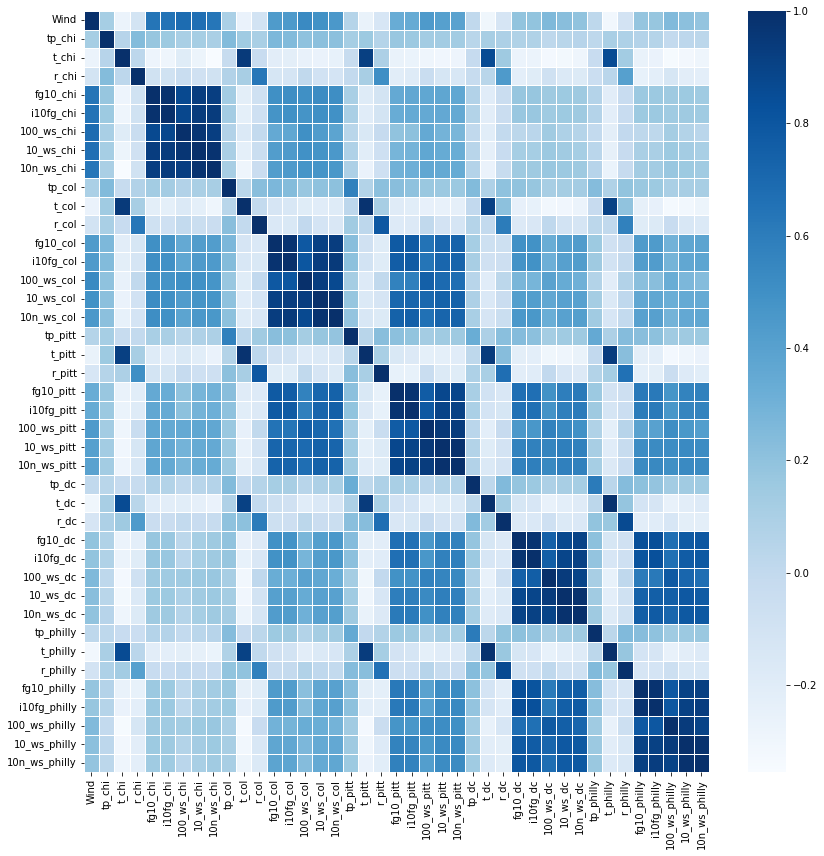

In [7]:
plt.figure(figsize=(14,14))

sns.heatmap(wind_corr, cmap = 'Blues', linewidth = 0.9)

plt.show()

<AxesSubplot:xlabel='time'>

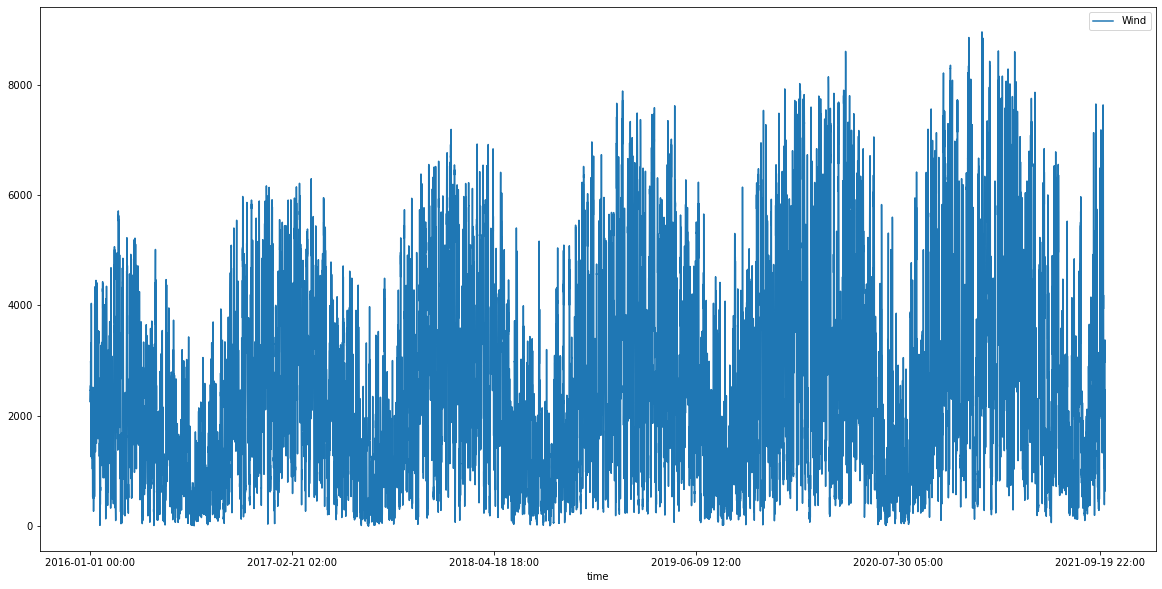

In [8]:
df_wind_all[['Wind']].plot(figsize=(20,10))

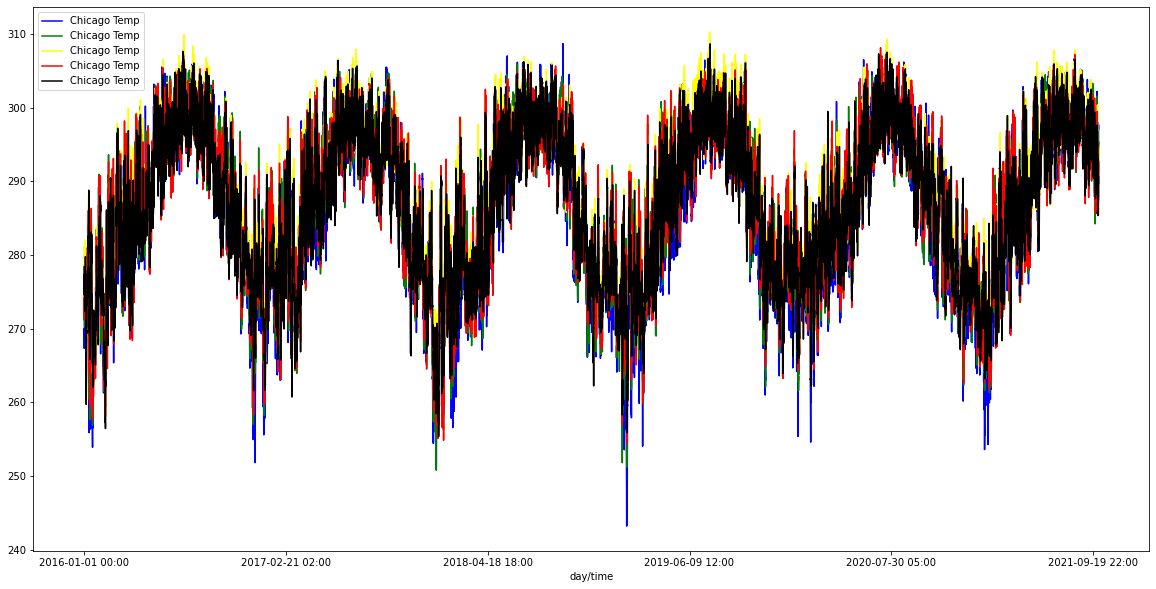

In [9]:
# Temperture Figure

plt.figure(figsize=(20,10))
df_wind_all['t_chi'].plot(label = 'Chicago Temp', color = 'blue')
df_wind_all['t_col'].plot(label = 'Chicago Temp', color = 'green')
df_wind_all['t_dc'].plot(label = 'Chicago Temp', color = 'yellow')
df_wind_all['t_pitt'].plot(label = 'Chicago Temp', color = 'red')
df_wind_all['t_philly'].plot(label = 'Chicago Temp', color = 'black')
plt.xlabel('day/time')
plt.legend()

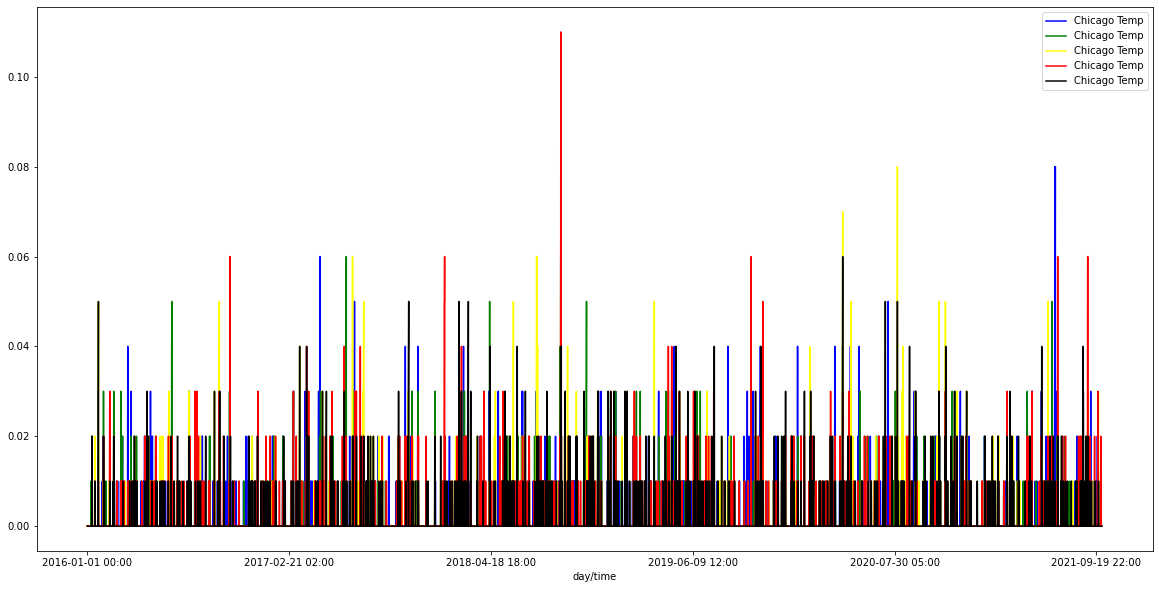

In [10]:
# Total Precipitation graph

plt.figure(figsize = (20,10))
df_wind_all['tp_chi'].plot(label = 'Chicago Temp', color = 'blue')
df_wind_all['tp_col'].plot(label = 'Chicago Temp', color = 'green')
df_wind_all['tp_dc'].plot(label = 'Chicago Temp', color = 'yellow')
df_wind_all['tp_pitt'].plot(label = 'Chicago Temp', color = 'red')
df_wind_all['tp_philly'].plot(label = 'Chicago Temp', color = 'black')
plt.xlabel('day/time')
plt.legend()

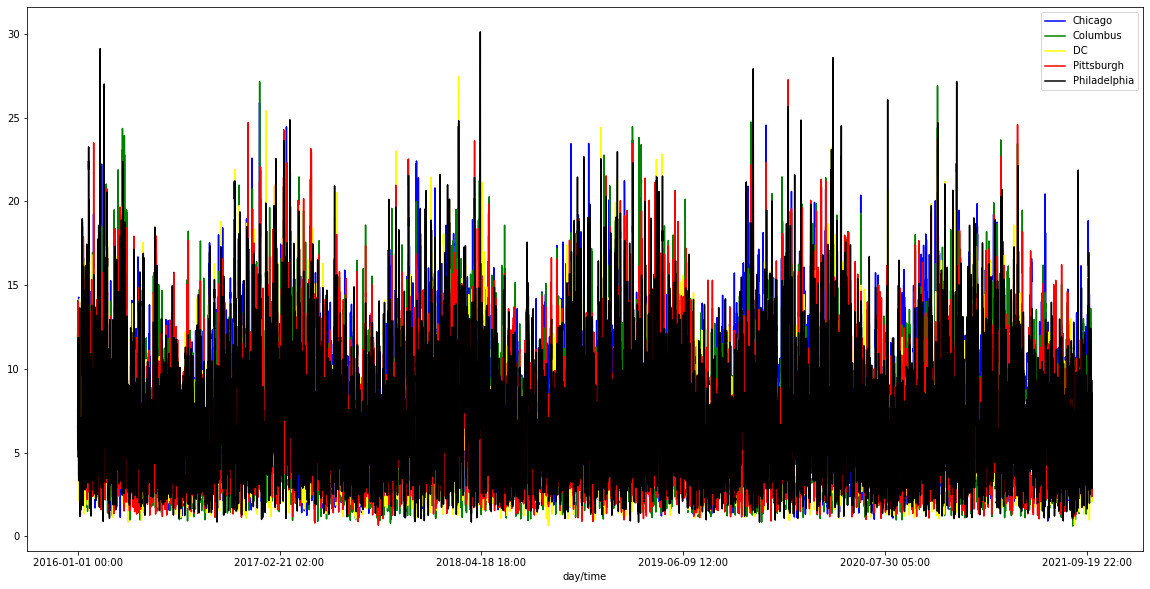

In [11]:
# Relative Humidity graph

plt.figure(figsize = (20,10))
df_wind_all['fg10_chi'].plot(label = 'Chicago', color = 'blue')
df_wind_all['fg10_col'].plot(label = 'Columbus', color = 'green')
df_wind_all['fg10_dc'].plot(label = 'DC', color = 'yellow')
df_wind_all['fg10_pitt'].plot(label = 'Pittsburgh', color = 'red')
df_wind_all['fg10_philly'].plot(label = 'Philadelphia', color = 'black')
plt.xlabel('day/time')
plt.legend()

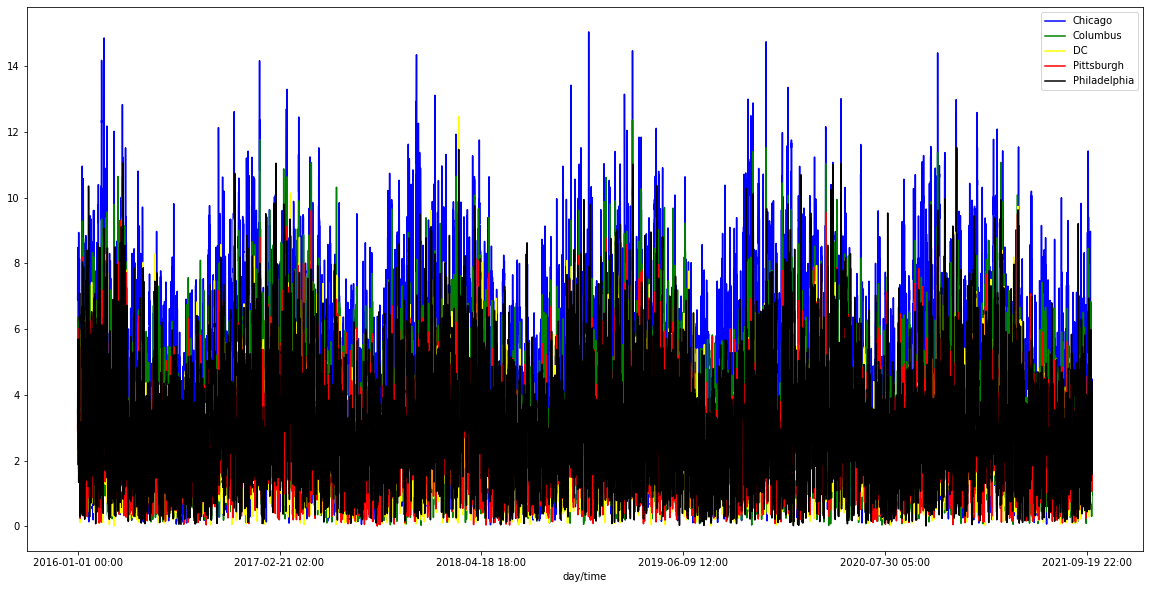

In [12]:
# 10m wind speed graph

plt.figure(figsize = (20,10))
df_wind_all['10_ws_chi'].plot(label = 'Chicago', color = 'blue')
df_wind_all['10_ws_col'].plot(label = 'Columbus', color = 'green')
df_wind_all['10_ws_dc'].plot(label = 'DC', color = 'yellow')
df_wind_all['10_ws_pitt'].plot(label = 'Pittsburgh', color = 'red')
df_wind_all['10_ws_philly'].plot(label = 'Philadelphia', color = 'black')
plt.xlabel('day/time')
plt.legend()

# Split the data and labels into train/test 

In [13]:
target = 'Wind'

# Split data into feature matrix and target 
y, X =df_wind_all['Wind'].to_numpy(), df_wind_all.drop(columns = target).to_numpy()

# Split data into test/train/val datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .3, random_state = 42)

# Keras NN with Tensorflow
Building the basic architecture of the model and then proceeding to train the model with early stopping in order to avoid overfitting of the model

In [14]:
# Define basic architecture
model_keras = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, 
                       input_shape=(X_train.shape[1],),
                       name='hidden_layer_1',),
    keras.layers.Dense(128, activation=tf.nn.relu,
                       name='hidden_layer_2',),
    keras.layers.Dense(128, activation=tf.nn.relu,
                       name='hidden_layer_3',),
    keras.layers.Dense(1, name='output_layer',)
])

# Define your optimizer asdf
optimizer = tf.optimizers.Adam()

model_keras.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae'])

# show a summary of the data
model_keras.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 128)               5248      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               16512     
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 128)               16512     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 38,401
Trainable params: 38,401
Non-trainable params: 0
_________________________________________________________________


2021-12-24 09:15:44.348913: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
# Function to plot how the model is doing during training
# Visualize the model's training progress using the stats stored in the history object. 
# We want to use this data to determine how long to train before the model stops making progress.
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()

2021-12-24 09:15:46.331517: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)



..................................................

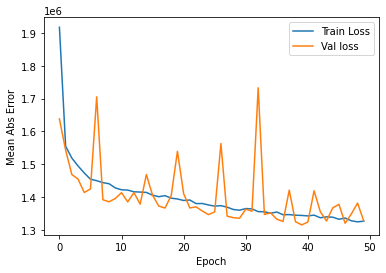

In [16]:
# If you train too long, you are prone to over-fitting
# this prevents the model from generalizing to data it has never seen before
# early stopping is one way to go about this
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Store training stats
history = model_keras.fit(X_train, y_train, epochs=70, batch_size=10,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

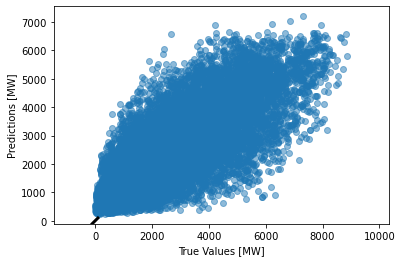

In [17]:
# Create a figure to show the test predictions vs true values
test_predictions_keras = model_keras.predict(X_test).flatten()

plt.scatter(y_test, test_predictions_keras, alpha = 0.5, zorder = 1)
plt.xlabel('True Values [MW]')
plt.ylabel('Predictions [MW]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100], color = 'black',lw =3, zorder = 10)

## Show model metrics to determine the accuracy of the model

In [18]:
# Show r2 score
from sklearn.metrics import r2_score
r2_score(y_test,test_predictions_keras)

0.5980077412663781

In [19]:
# Show mse and mae
mse = mean_squared_error(y_test, test_predictions_keras)
print(f'the rmse is {mse**(1/2)}')

mae = mean_absolute_error(y_test,test_predictions_keras)
print(f'the mae is {mae}')

the rmse is 1145.247918079517
the mae is 857.1768033946037


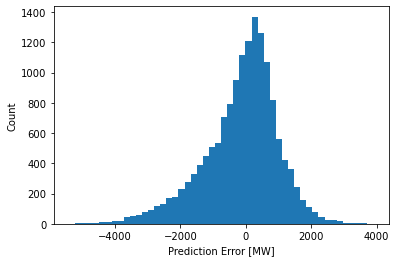

In [20]:
error = test_predictions_keras - y_test
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [MW]")
_ = plt.ylabel("Count")

# Determining optimal hyperparameters for NN with Scikitlearn
Finding the optimal batch size and number of epochs for fitting the nn

In [ ]:
# Define your neural network model as a function
def create_model():
    model = Sequential()
    model.add(Dense(128, input_shape=(X_train.shape[1],),kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(128, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(128, kernel_initializer=init_mode, activation='relu'))
    model.compile(loss='mse', optimizer= 'adam', metrics=['mae'])
    return model

In [ ]:
# Create a KerasClassifier model using your model definition function as an argument
model = KerasRegressor(build_fn=create_model, verbose=0)

In [ ]:
param_grid_1 = dict(batch_size=[10, 40, 80], epochs=[60, 70, 80])
print(param_grid_1)

In [ ]:
%%time
# Perform the grid search 

grid_1 = GridSearchCV(estimator=model, param_grid=param_grid_1)
grid_result_1 = grid_1.fit(X, y, callbacks=[PrintDot()])

In [ ]:
# Summarize the results
def summarize_results(grid_result):
    means = grid_result.cv_results_['mean_test_score']
    params = grid_result.cv_results_['params']
    print('Results')
    for mean, param in zip(means, params):
        print(f'{param} -- {mean.round(3)}')
    print('')
    print(f'Best: {grid_result.best_score_.round(3)} using {grid_result.best_params_}')
summarize_results(grid_result_1)

# Random Forest and XGBoost 
The following parameters were the final hyperparameters established for training both the random forest regression and xgboost regression models

In [21]:
# RFR parameters (random forest regression)
params_rfr = {'n_estimators':1000,
              'criterion':'mse', 
              'ccp_alpha':0.01,
              'max_depth': 20,
              'min_samples_leaf':1,
              'min_samples_split':5,
              'bootstrap':True,
              'max_features':None}


# XGB parameters (extreme gradient boosting)
params_xgb = {'objective': 'reg:squarederror',
              #'base_score': 0.5,     # chosen as median of validation set
              'n_estimators': 1000,  # number of trees to use
              'learning_rate': 0.01, 
              'max_depth': 20,       # how many levels are in each tree
              'subsample': 0.5,
              'colsample_bytree': 0.4,
              'colsample_bylevel': 0.7,
              # REGULARIZATION  alpha (L2) and lambda (L1)
              'reg_alpha': 0,
              'reg_lambda': 1,}

## Hyperparameter Tuning
The following section of this file defines the range of hyperparameters to undergo either a grid or random search to find the optimal parameters. Random search was used more often than grid search due to the limited RAM capacity on the laptop used for training the model.

In [22]:
# Random Forest Hyperparameter Tuning
# GridSearchCV parameters
params_grid_rfr = {'n_estimators':[1000],
              'ccp_alpha':[0.01,0.02],
              'max_depth': [10,20],
              'min_samples_leaf':[1,2],
              'min_samples_split':[5,6],
              'bootstrap':[True],
              'max_features':[None]}


# XGBoost Hyperparameter Tuning
# GridSearchCV parameters
params_grid_xgb = { 'max_depth': [10,20],
           'learning_rate': [0.01],
           'n_estimators': [1000,2000],
           'subsample': np.arange(0.4, 1.0, 0.05),
           'colsample_bytree': np.arange(0.4, 1.0, 0.05),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.05),
         }

# RandomSearchCV parameters
params_rand_xgb = { 'max_depth': [10, 15, 20],
           'learning_rate': [0.01, 0.1],
           'subsample': np.arange(0.4, 1.0, 0.05),
           'colsample_bytree': np.arange(0.4, 1.0, 0.05),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.05),
           'n_estimators': [1000, 2000]}

In [23]:
# Define the model
# Random Forest
model_rfr = RandomForestRegressor(**params_rfr) # used for fitting the model
model_rfr2 = RandomForestRegressor() # used for grid and random search

# XGBoost
model_xgb = XGBRegressor(**params_xgb) # used for fitting the model
model_xgb2 = XGBRegressor(seed=20 ) # used for grid and random search

In [ ]:
%%time

# Perform GridSearch 
clf_grid = GridSearchCV(estimator= model_rfr2, 
                   param_grid=params_grid_rfr,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

# Perform RandomizedSearch
clf_rand = RandomizedSearchCV(estimator=model_rfr2,
                         param_distributions=params_rand_rfr,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1)

clf_grid.fit(X, y)

In [ ]:
# Print out best parameters for xgboost method
print("Best parameters:", clf_rand.best_params_)
print("Lowest RMSE: ", (-clf_rand.best_score_)**(1/2.0))

## Train model according to new Hyperparameters
For when manually inputting the hyperparameters into the model fit to see whether the optimal MAE and RMSE were obtained

In [25]:
%%time
model_rfr.fit(X_train, y_train)
#model_xgb.fit(X_train, y_train)

/Users/christianealford/opt/anaconda3/envs/mlProject/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:392: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


CPU times: user 12min 8s, sys: 3.55 s, total: 12min 11s
Wall time: 12min 13s


RandomForestRegressor(ccp_alpha=0.01, criterion='mse', max_depth=20,
                      max_features=None, min_samples_split=5,
                      n_estimators=1000)

## Random Forest Prediction plot and metrics
Plot the test predictions against the labeled test data  and then the error of the predictions in bins of 50

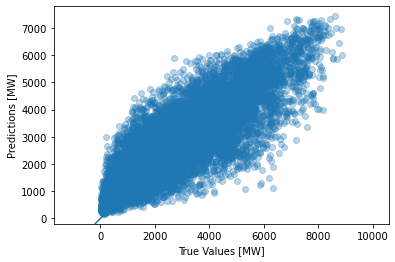

In [26]:
# Plot predictions against true values
test_predictions_rfr = model_rfr.predict(X_test)

plt.scatter(y_test, test_predictions_rfr, alpha = 0.3)
plt.xlabel('True Values [MW]')
plt.ylabel('Predictions [MW]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-250, 250], [-250, 250])

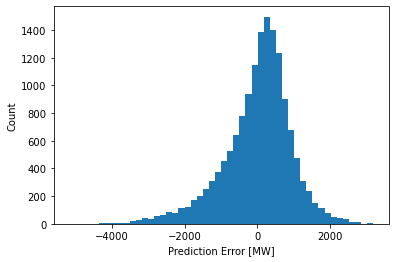

In [27]:
error_rfr = test_predictions_rfr - y_test
plt.hist(error_rfr, bins = 50)
plt.xlabel("Prediction Error [MW]")
_ = plt.ylabel("Count")

In [28]:
# Get r2 score
r2_score(y_test,test_predictions_rfr)

0.7298122235513147

In [29]:
# Show mse and mae
mse = mean_squared_error(y_test, test_predictions_rfr)
print(f'the rmse is {mse**(1/2)}')

mae = mean_absolute_error(y_test,test_predictions_rfr)
print(f'the mae is {mae}')

the rmse is 938.9090272390516
the mae is 703.8829633710975


## XGBoost Prediction plot and metrics

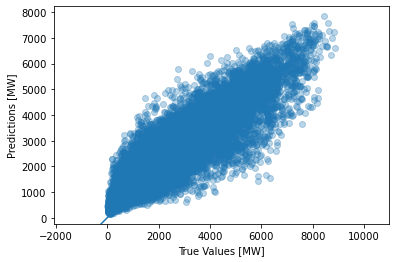

In [30]:
# Plot predictions against true values
test_predictions_xgb = model_xgb.predict(X_test)

plt.scatter(y_test, test_predictions_xgb, alpha = 0.3)
plt.xlabel('True Values [MW]')
plt.ylabel('Predictions [MW]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-250, 250], [-250, 250])

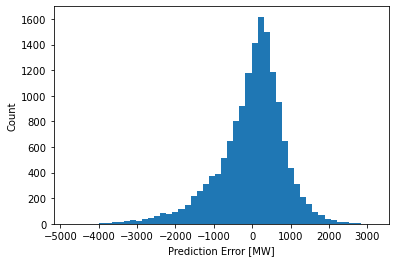

In [31]:
error_xgb = test_predictions_xgb - y_test
plt.hist(error_xgb, bins = 50)
plt.xlabel("Prediction Error [MW]")
_ = plt.ylabel("Count")

In [32]:
# r2 score xgb
r2_score(y_test,test_predictions_xgb)

0.7719852411517995

In [33]:
# Show mse and mae
mse = mean_squared_error(y_test, test_predictions_xgb)
print(f'the rmse is {mse**(1/2)}')

mae = mean_absolute_error(y_test,test_predictions_xgb)
print(f'the mae is {mae}')

the rmse is 862.5259008622213
the mae is 640.3011090971385


# Feature Importance

In [34]:
# Plot Feature Importance
def plot_feature_importance(importance, names):
    '''
    this code is from here: 
    https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
    '''
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,14))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [35]:
# Set the data to a new data frame that excludes the target variables
df = df_wind_all.drop(columns = target)

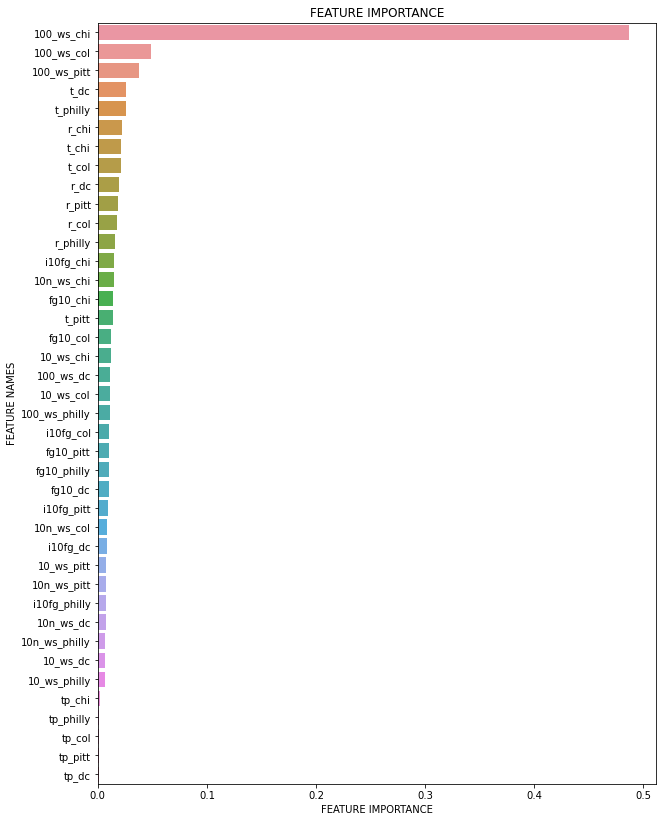

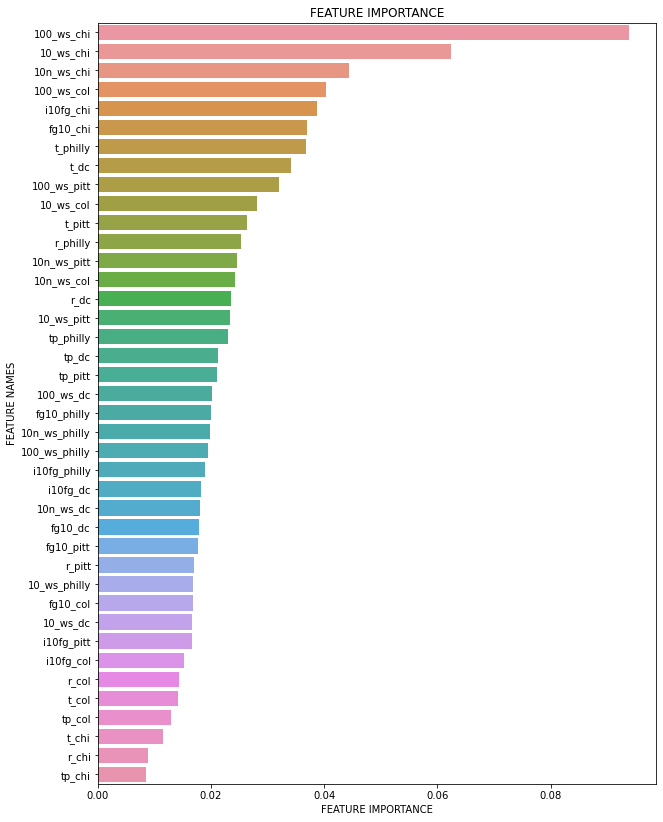

In [36]:
# Plot feature importance for each model
# Random Forest
plot_feature_importance(model_rfr.feature_importances_, df.columns)

# XGBoost
plot_feature_importance(model_xgb.feature_importances_, df.columns)